In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

dir_path = "/content/drive/My Drive/Big Data Research Paper/"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Step 1: Load Data
file_path = '/content/drive/My Drive/Big Data Research Paper/SupplyChainDataset.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1', parse_dates=['order date (DateOrders)'])

# Rename date column for convenience
df.rename(columns={'order date (DateOrders)': 'OrderDate'}, inplace=True)

In [ ]:


# Aggregate daily sales
df = df.groupby('OrderDate').agg({'Sales': 'sum'})
df.index = pd.to_datetime(df.index)  # Ensure datetime index

# Step 2: Create Time Features
df['dayofyear'] = df.index.dayofyear
df['hour'] = df.index.hour  # if no hour, this will be zero
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year

# Step 3: Create Lag Features
LAGS = [1, 2, 3, 7, 14, 30]
for lag in LAGS:
    df[f'lag_{lag}'] = df['Sales'].shift(lag)

df = df.dropna()



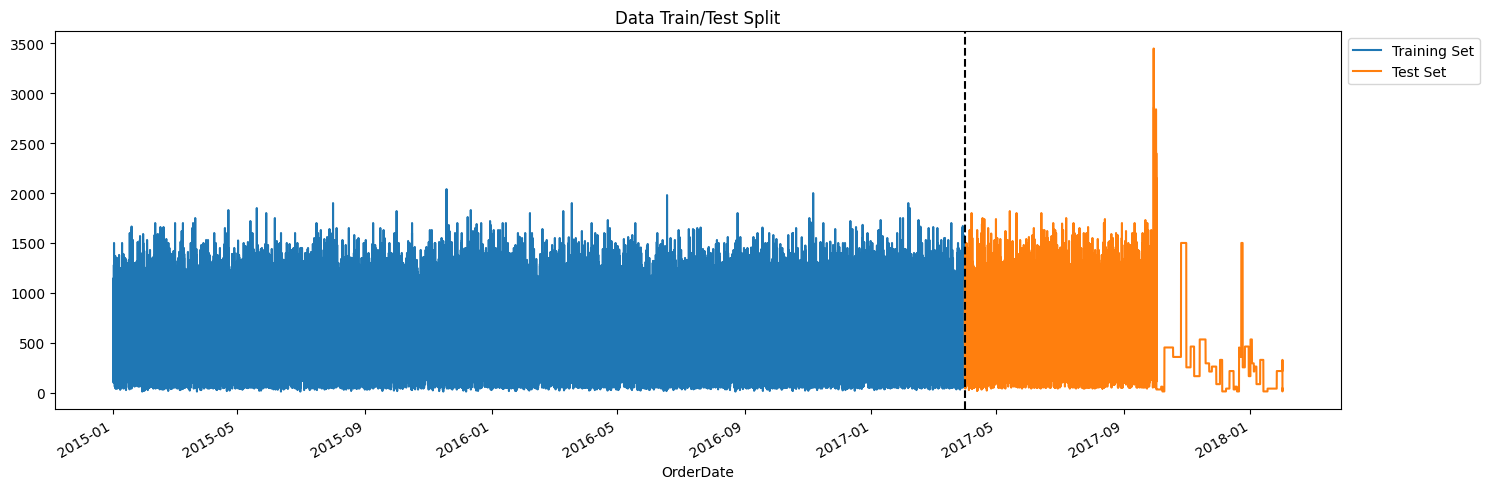

In [ ]:
# Step 4: Train-Test Split
split_date = '2017-04-01'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

# Plot: Train/Test Split
fig, ax = plt.subplots(figsize=(15, 5))
train['Sales'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Sales'].plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')

# Place legend outside upper right
ax.legend(['Training Set', 'Test Set'],
          loc='upper left',
          bbox_to_anchor=(1.0, 1.0))

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

In [ ]:


# Step 5: Prepare Features & Target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year'] + [f'lag_{lag}' for lag in LAGS]
TARGET = 'Sales'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

# Step 6: Train XGBoost Model
reg = XGBRegressor(objective='reg:squarederror', n_estimators=100)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

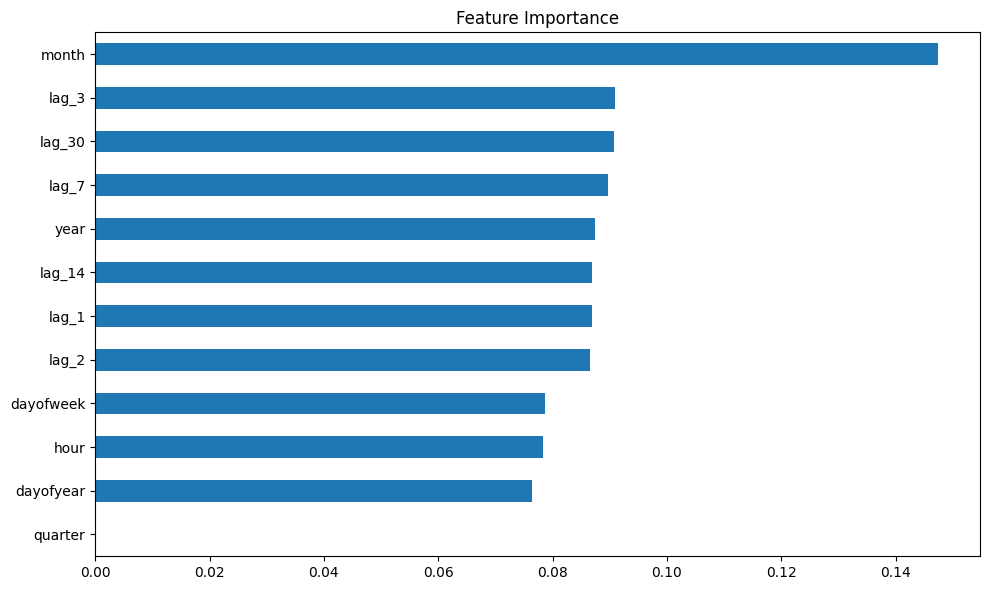

In [ ]:


# Step 7: Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

# Plot
ax = fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10, 6))

ax.get_legend().remove()

# Adjust layout to make space for the legend
plt.tight_layout()

plt.show()

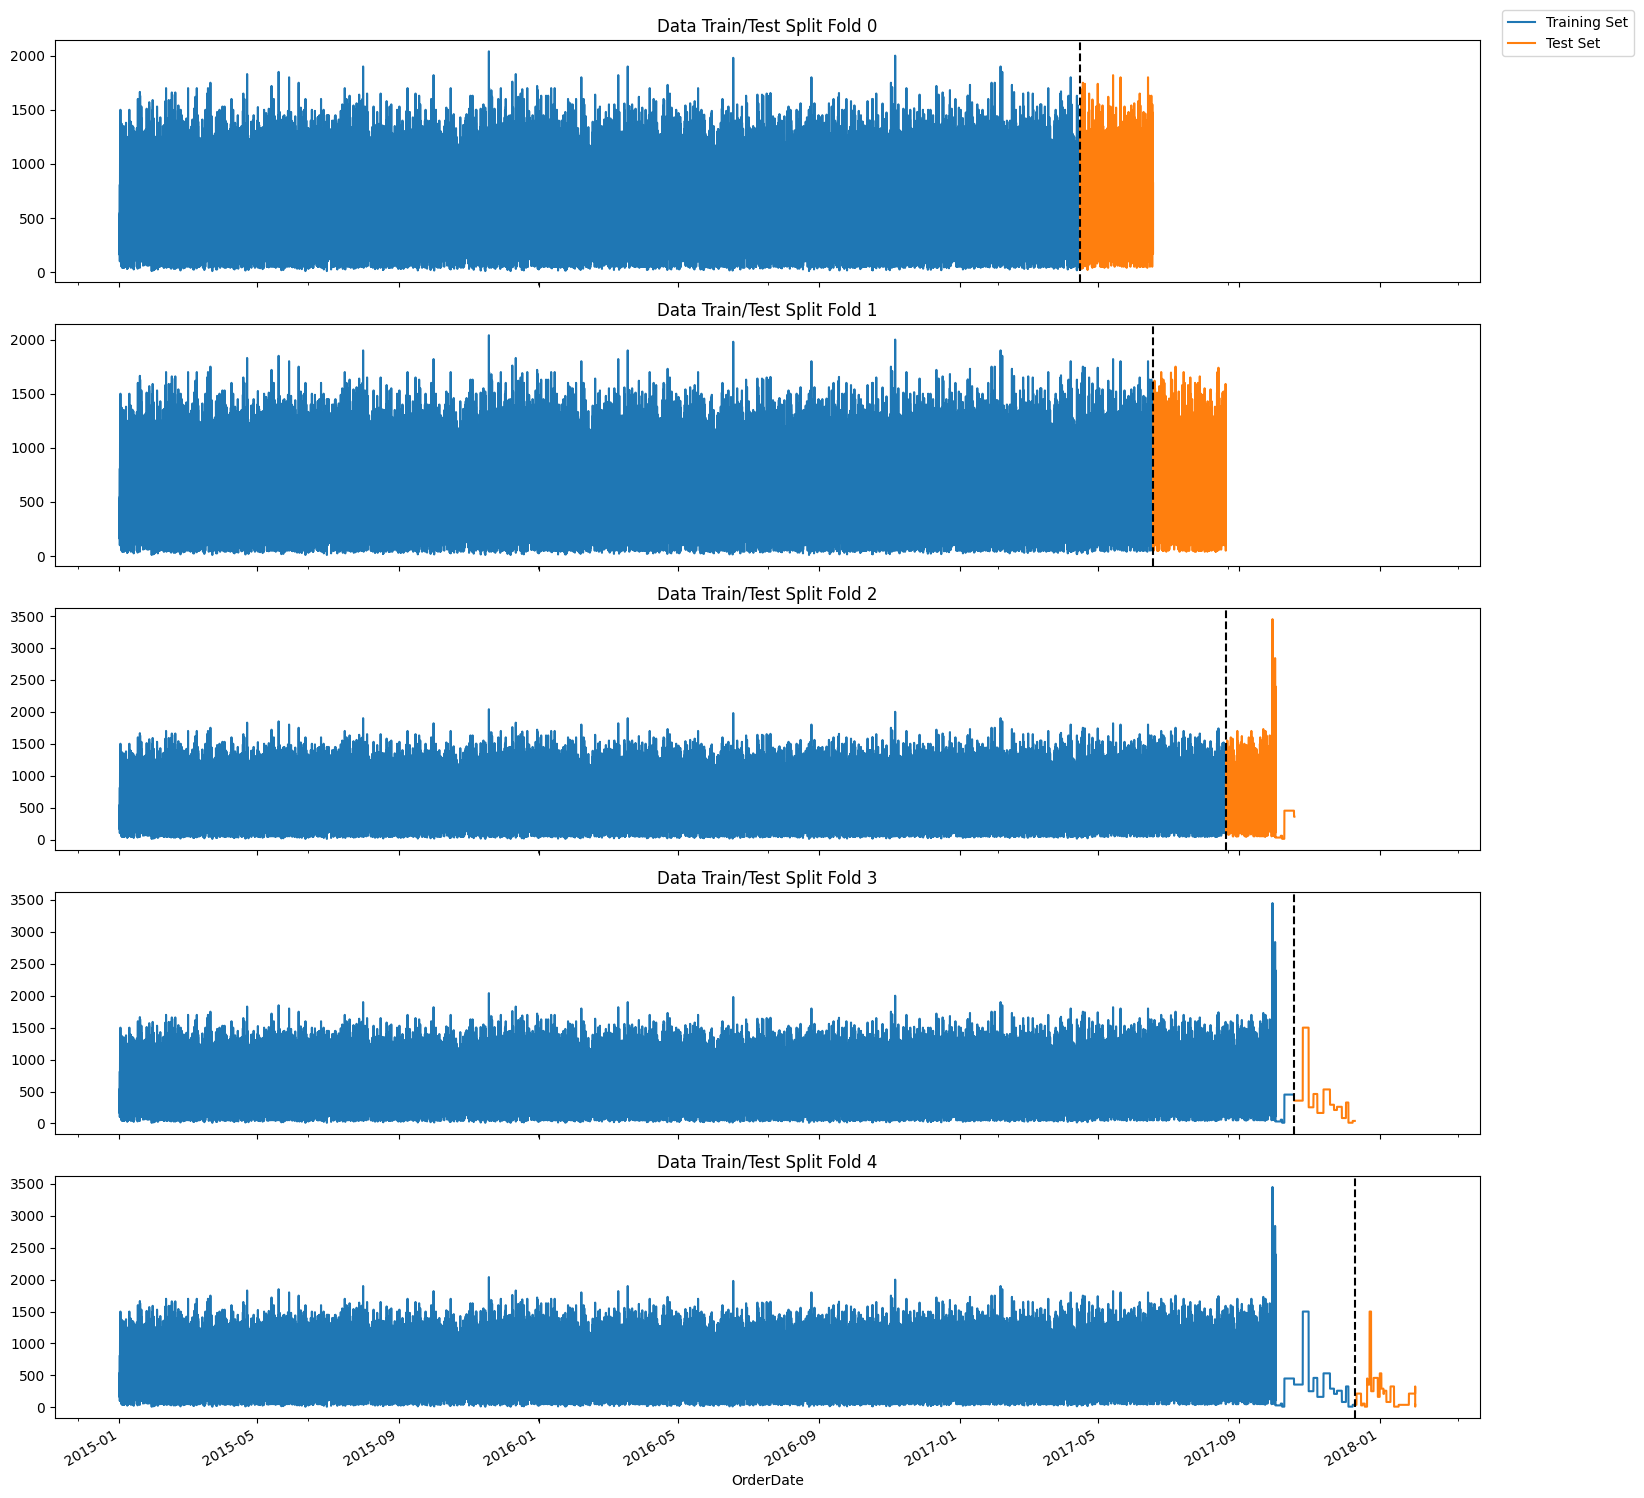

In [ ]:
# Step 8: Time Series Cross-Validation Plot
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 150 * 1, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train_fold = df.iloc[train_idx]
    val_fold = df.iloc[val_idx]
    train_fold['Sales'].plot(ax=axs[fold],
                             label='Training Set',
                             title=f'Data Train/Test Split Fold {fold}')
    val_fold['Sales'].plot(ax=axs[fold],
                           label='Test Set')
    axs[fold].axvline(val_fold.index.min(), color='black', ls='--')
    fold += 1

# Add a single legend to the figure
fig.legend(['Training Set', 'Test Set'],
           loc='upper left',
           bbox_to_anchor=(1.0, 1.0))

# Adjust layout to make space for the legend
plt.tight_layout()

plt.show()

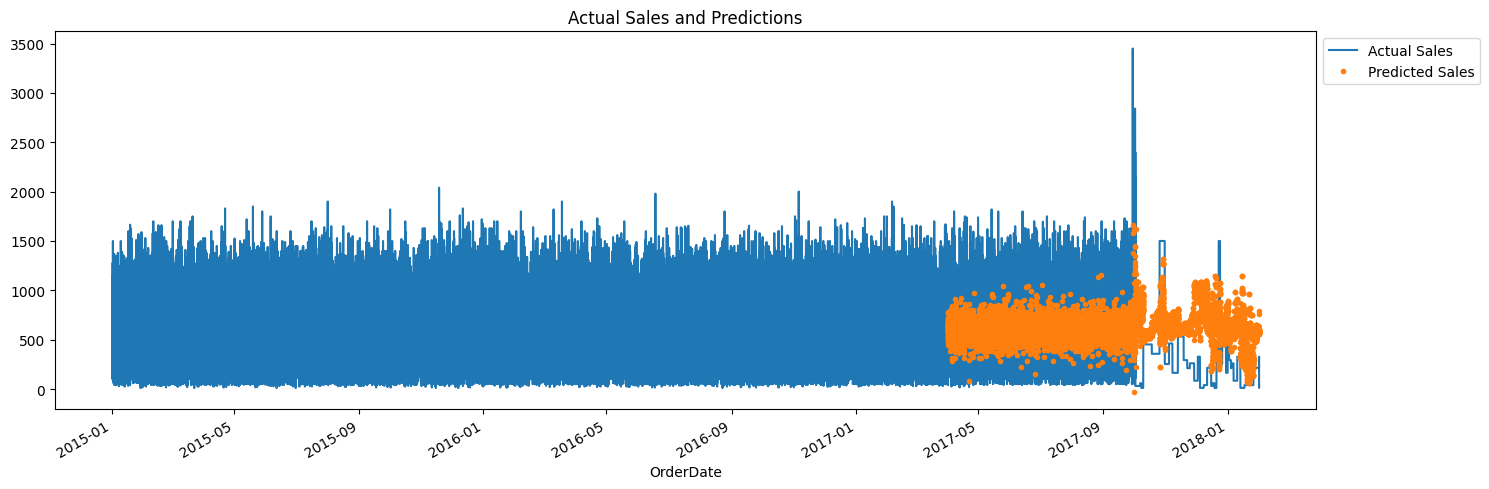

In [ ]:


# Step 9: Predictions
test['prediction'] = reg.predict(X_test)

# Merge predictions into original dataframe
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


ax = df[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')

# Place legend outside upper right
ax.legend(['Actual Sales', 'Predicted Sales'],
          loc='upper left',
          bbox_to_anchor=(1.0, 1.0))

# Set title
ax.set_title('Actual Sales and Predictions')

# Adjust layout to make space for the legend
plt.tight_layout()

plt.show()

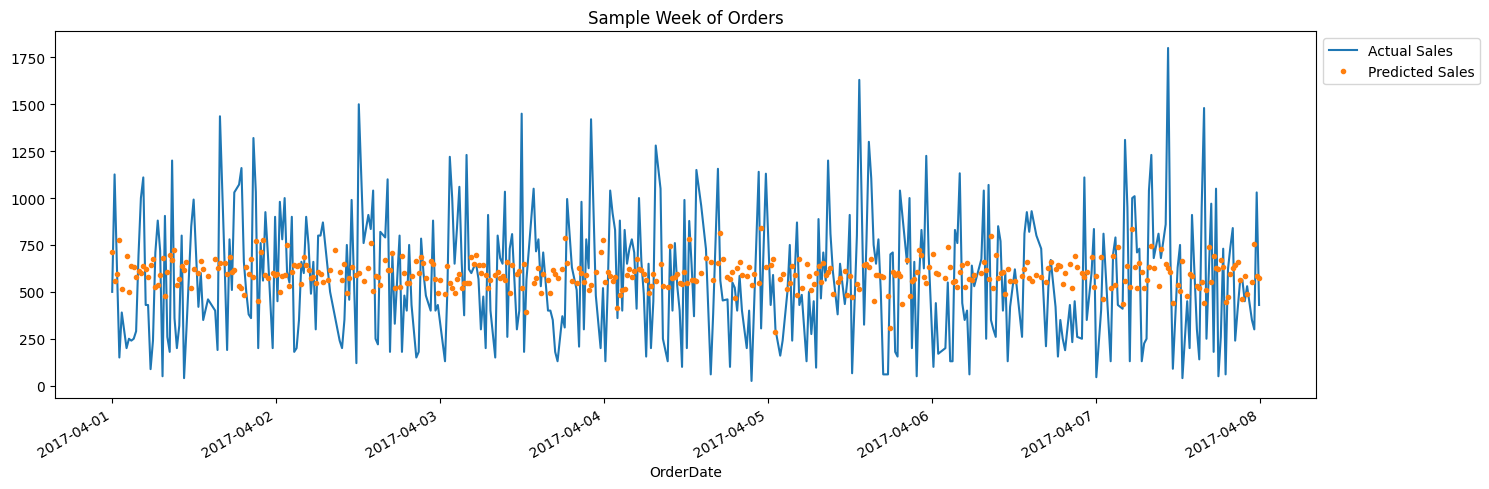

RMSE Score on Test set: 436.24
date
2017-11-30    917.501319
2017-10-05    908.339561
2017-12-07    905.627841
2017-12-01    895.396437
2017-12-05    887.968248
2017-10-03    886.771950
2017-12-11    875.172017
2017-10-04    866.474129
2017-12-23    866.235536
2017-12-06    858.274321
Name: error, dtype: float64


In [ ]:
# Step 10: Zoom in for a Sample Week
sample_start = '2017-04-01'
sample_end = '2017-04-08'

ax = df.loc[(df.index > sample_start) & (df.index < sample_end)][TARGET] \
    .plot(figsize=(15, 5), title='Sample Week of Orders')
df.loc[(df.index > sample_start) & (df.index < sample_end)]['prediction'] \
    .plot(style='.', ax=ax)

# Place legend outside upper right
ax.legend(['Actual Sales', 'Predicted Sales'],
          loc='upper left',
          bbox_to_anchor=(1.0, 1.0))

# Adjust layout
plt.tight_layout()
plt.show()

# Step 11: Evaluate Model
score = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

# Step 12: Errors by date
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
print(test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10))